In [45]:
import numpy as np

# Constants
R = 287.05
g = 9.80665
T0 = 288.15
p0 = 101325
rho0 = 1.225
L = 0.0065
CRUD = 1.15

# ISA Model
def isa_density(alt_ft):
    alt_m = alt_ft * 0.3048
    if alt_m <= 11000:
        T = T0 - L * alt_m
        p = p0 * (T / T0) ** (g / (L * R))
    else:
        T = 216.65
        p_11 = p0 * (216.65 / T0) ** (g / (L * R))
        p = p_11 * np.exp(-g * (alt_m - 11000) / (R * T))
    rho = p / (R * T)
    return rho, T

# Reynolds and Skin Friction
def reynolds_number(V, rho, L=21.3, mu=1.789e-5):
    return (rho * V * L) / mu

def skin_friction_coeff(Re, M):
    if Re <= 0:
        return 0.0
    Cf_turb = 0.455 / ((np.log10(Re))**2.58) * (1 + 0.144 * M**2)**0.65
    return Cf_turb

# Flap Drag
def flap_drag_correction(deflection_deg, S_flaps, S_ref):
    k_f = 0.12
    return k_f * (S_flaps / S_ref) * (np.sin(np.radians(deflection_deg)))**1.2

# Wave Drag
def wave_drag(M, M_cr=0.85):
    if M > M_cr:
        k = 2.2
        n = 2
        return k * (M - M_cr)**n
    return 0.0

# Miscellaneous Drag
def miscellaneous_drag(S_control, S_upsweep, S_washout, S_ref, delta_trim, theta_upsweep, theta_washout):
    k_trim = 0.0003
    k_upsweep = 0.0002
    k_washout = 0.0001
    CD_trim = k_trim * (S_control / S_ref) * (delta_trim ** 2)
    CD_upsweep = k_upsweep * (S_upsweep / S_ref) * (theta_upsweep ** 2)
    CD_washout = k_washout * (S_washout / S_ref) * (theta_washout ** 2)
    return CD_trim + CD_upsweep + CD_washout

# Induced Drag
def induced_drag(CL, AR):
    e = 0.966183575
    return (CL**2) / (np.pi * AR * e)

# Drag Force
def compute_drag(rho, V, S, CD):
    return 0.5 * rho * V**2 * S * CD

# Lift-to-Drag Ratio
def compute_lift_to_drag(CL, CD):
    if CD == 0:
        return 0.0
    return CL / CD

# Aircraft Data
S_ref =1281.44354# ft²
S_ref_m2 = S_ref/10.764 #1336 m2 120.25 m²
AR = 7.040 # 6.9
S_wet =  411.189 # m²
S_flaps = 0.18 * S_ref # ft² 18% of the reference area 
W = 105682.71  * 4.44822  # N
print(W)
# Flight Segments
flight_segments = {
    "Takeoff": {"V_knots": 135, "alt_ft": 0, "flaps": True, "deflection_deg": 20},
    "Climb": {"V_knots": 250, "alt_ft": 10000, "flaps": False, "deflection_deg": 0},
    "Cruise": {"V_knots": 517, "alt_ft": 41000, "flaps": False, "deflection_deg": 0},
    "Landing": {"V_knots": 120, "alt_ft": 0, "flaps": True, "deflection_deg": 40},
}

# Compute Drag
for segment, params in flight_segments.items():
    V = params["V_knots"] * 0.514444
    rho, T = isa_density(params["alt_ft"])
    M = V / np.sqrt(1.4 * R * T)
    q = 0.5 * rho * V**2
    CL = W / (q * S_ref_m2)#0.45

    Re = reynolds_number(V, rho)
    Cf = skin_friction_coeff(Re, M)
    CD0_friction = Cf * 1.2 * S_wet / S_ref_m2  # Form factor 1.2
    CD_misc = miscellaneous_drag(160, 80, 160, S_ref, 5, 10, 5)
    CD_flaps = flap_drag_correction(params["deflection_deg"], S_flaps, S_ref) if params["flaps"] else 0
    CD_gear = 0.025 if segment in ["Takeoff", "Landing"] else 0
    CD0 = CD0_friction + CD_misc + CD_flaps + CD_gear
    CD_climb_increment = 0.007 if segment == "Climb" else 0
    CD0 += CD_climb_increment
    CDi = induced_drag(CL, AR)
    CD_wave = wave_drag(M)
    CD_total = CD0 * CRUD + CDi + CD_wave

    Drag_force = compute_drag(rho, V, S_ref_m2, CD_total)
   # L_over_D = compute_lift_to_drag(CL, CD_total)

    print(f"{segment}:")
    print(f"  Velocity: {V:.2f} m/s ({params['V_knots']} knots)")
    print(f"  Air Density: {rho:.3f} kg/m³")
    print(f"  Mach Number: {M:.3f}")
    print(f"  Lift Coefficient (CL): {CL:.3f}")
    print(f"  Friction Drag Coefficient: {CD0_friction:.5f}")
    print(f"  Miscellaneous Drag Coefficient: {CD_misc:.5f}")
    print(f"  Flap Drag Coefficient: {CD_flaps:.5f}")
    print(f"  Gear Drag Coefficient: {CD_gear:.5f}")
    print(f"  Climb Increment Drag Coefficient: {CD_climb_increment:.5f}")
    print(f"  Minimum Drag Coefficient (CD0): {CD0:.5f}")
    print(f"  Induced Drag Coefficient (CDi): {CDi:.5f}")
    print(f"  Wave Drag Coefficient: {CD_wave:.5f}")
    print(f"  Total Drag Coefficient (CD): {CD_total:.5f}")
    print(f"  Drag Force: {Drag_force:.2f} N ({Drag_force / 4.44822:.2f} lbf)\n")
    #print(f"  Lift-to-Drag Ratio (L/D): {L_over_D:.2f}\n")

470099.9442762
Takeoff:
  Velocity: 69.45 m/s (135 knots)
  Air Density: 1.225 kg/m³
  Mach Number: 0.204
  Lift Coefficient (CL): 1.337
  Friction Drag Coefficient: 0.00884
  Miscellaneous Drag Coefficient: 0.00250
  Flap Drag Coefficient: 0.00596
  Gear Drag Coefficient: 0.02500
  Climb Increment Drag Coefficient: 0.00000
  Minimum Drag Coefficient (CD0): 0.04230
  Induced Drag Coefficient (CDi): 0.08361
  Wave Drag Coefficient: 0.00000
  Total Drag Coefficient (CD): 0.13225
  Drag Force: 46512.72 N (10456.48 lbf)

Climb:
  Velocity: 128.61 m/s (250 knots)
  Air Density: 0.905 kg/m³
  Mach Number: 0.392
  Lift Coefficient (CL): 0.528
  Friction Drag Coefficient: 0.00855
  Miscellaneous Drag Coefficient: 0.00250
  Flap Drag Coefficient: 0.00000
  Gear Drag Coefficient: 0.00000
  Climb Increment Drag Coefficient: 0.00700
  Minimum Drag Coefficient (CD0): 0.01805
  Induced Drag Coefficient (CDi): 0.01304
  Wave Drag Coefficient: 0.00000
  Total Drag Coefficient (CD): 0.03379
  Drag Forc

In [ ]:
import numpy as np

# Constants
R = 287.05  # J/(kg*K)
g = 9.80665  # m/s²
T0 = 288.15  # K
p0 = 101325  # Pa
rho0 = 1.225  # kg/m³
L = 0.0065  # K/m
MTOW = 105682.71 # lb
MFW = 44328.82  # lb
RESERVE_FUEL = 2110.90  # lb
T_SL_per_engine = 20000  # lbf
S_takeoff = 1307.56  # m

# Segment-Specific Weights approximations in percentages 
W_takeoff = MTOW * 4.44822  # N
W_climb = (MTOW - 0.05 * MFW) * 4.44822  # 5% fuel burn
W_cruise = (MTOW - 0.5 * MFW) * 4.44822  # 50% fuel burn
W_landing = (MTOW - (MFW - RESERVE_FUEL)) * 4.44822  # Burn all non-reserve fuel

# ISA Model
def isa_density(alt_ft):
    alt_m = alt_ft * 0.3048
    if alt_m <= 11000:
        T = T0 - L * alt_m
        p = p0 * (T / T0) ** (g / (L * R))
    else:
        T = 216.65
        p_11 = p0 * (216.65 / T0) ** (g / (L * R))
        p = p_11 * np.exp(-g * (alt_m - 11000) / (R * T))
    rho = p / (R * T)
    return rho, T

# Mach Correction for Thrust
def mach_correction(M):
    return 1 - 0.2 * M

# Flight Segments with Updated Drag Values
flight_segments = {
    "Takeoff": {"V_knots": 135, "alt_ft": 0, "drag_lbf": 10456.48, "ROC_ft_min": 0, "weight": W_takeoff},
    "Climb": {"V_knots": 250, "alt_ft": 10000, "drag_lbf": 6766.41, "ROC_ft_min": 2000, "weight": W_climb},
    "Cruise": {"V_knots": 517, "alt_ft": 41000, "drag_lbf": 7287.52, "ROC_ft_min": 0, "weight": W_cruise},
    "Landing": {"V_knots": 120, "alt_ft": 0, "drag_lbf": 11900.11, "ROC_ft_min": 0, "weight": W_landing},
}

# Compute Thrust
for segment, params in flight_segments.items():
    V = params["V_knots"] * 0.514444  # m/s
    rho, T = isa_density(params["alt_ft"])
    M = V / np.sqrt(1.4 * R * T)
    
    # Required Thrust
    D = params["drag_lbf"] * 4.44822  # Newton
    ROC = params["ROC_ft_min"] * 0.00508  # m/s
    sin_theta = ROC / V if ROC > 0 else 0
    T_req_N = D + params["weight"] * sin_theta
    
    # Add acceleration force for takeoff
    if segment == "Takeoff":
        a = (V ** 2) / (2 * S_takeoff)  # m/s^2
        F_accel = (params["weight"] / g) * a  # Newton
        T_req_N += F_accel
    
    T_req_lbf = T_req_N / 4.44822  # required thrust in lbs
    
    # Available Thrust
    rho_ratio = rho / rho0
    f_M = mach_correction(M)
    T_avail_per_engine = T_SL_per_engine * (rho_ratio ** 0.8) * f_M
    T_avail_total = 2 * T_avail_per_engine  # Twin engines

    # Compute thrust margin in percentage
    T_margin = T_avail_total - T_req_lbf
    T_margin_percent = (T_margin / T_req_lbf) * 100  # Convert to percentage
    
    print(f"{segment}:")
    print(f"  Velocity: {V:.2f} m/s ({params['V_knots']:.2f} knots)")
    print(f"  Air Density: {rho:.3f} kg/m³")
    print(f"  Mach Number: {M:.3f}")
    print(f"  Density Ratio (ρ/ρ₀): {rho_ratio:.3f}")
    print(f"  Mach Correction (f(M)): {f_M:.3f}")
    print(f"  Required Thrust: {T_req_lbf:.2f} lbf")
    print(f"  Available Thrust: {T_avail_total:.2f} lbf")
    print(f"  Thrust Margin:    {T_margin_percent:.2f} %")

    # Check if thrust margin is below recommended level
    min_margin = {"Takeoff": 10, "Climb": 20, "Cruise": 5, "Landing": 10}
    if T_margin_percent < min_margin[segment]:
        print("  ⚠️ Warning: Low thrust margin! Check for performance issues.\n")
    else:
        print("  ✅ Sufficient thrust available.\n")

Takeoff:
  Velocity: 69.45 m/s (135.00 knots)
  Air Density: 1.225 kg/m³
  Mach Number: 0.204
  Density Ratio (ρ/ρ₀): 1.000
  Mach Correction (f(M)): 0.959
  Required Thrust: 30332.77 lbf
  Available Thrust: 36449.21 lbf
  Thrust Margin:    20.16 %
  ✅ Sufficient thrust available.

Climb:
  Velocity: 128.61 m/s (250.00 knots)
  Air Density: 0.905 kg/m³
  Mach Number: 0.392
  Density Ratio (ρ/ρ₀): 0.738
  Mach Correction (f(M)): 0.922
  Required Thrust: 14940.03 lbf
  Available Thrust: 27480.97 lbf
  Thrust Margin:    83.94 %
  ✅ Sufficient thrust available.

Cruise:
  Velocity: 265.97 m/s (517.00 knots)
  Air Density: 0.287 kg/m³
  Mach Number: 0.901
  Density Ratio (ρ/ρ₀): 0.235
  Mach Correction (f(M)): 0.820
  Required Thrust: 7287.52 lbf
  Available Thrust: 9766.48 lbf
  Thrust Margin:    34.02 %
  ✅ Sufficient thrust available.

Landing:
  Velocity: 61.73 m/s (120.00 knots)
  Air Density: 1.225 kg/m³
  Mach Number: 0.181
  Density Ratio (ρ/ρ₀): 1.000
  Mach Correction (f(M)): 0.96

In [ ]:
# Function to calculate air density using the ISA model
# Up to 11 km (Troposphere)
R = 287.05  # [m^2/s^2K]
gamma = 1.4
T_0 = 288.15 #[K]
rho_0 = 1.225  #[kg/m^3]
g = 9.81 #[m/s^2]
L =  0.0065
p_0 = 101325

def air_density(altitude):
    # Up to 11 km (Troposphere)
    if altitude <= 11000:
        T = T_0 - L * altitude  # Temperature [K]
        p = p_0 * (T / 288.15) ** 5.2561  # Pressure [Pa]
    else:
        # Simplification for stratosphere, constant T [K] above 11 km
        T = 216.65  # Constant temperature [K]
        p = 22632 * np.exp(-9.81 * (altitude - 11000) / (287.05 * T))
    rho = p / (287.05 * T)  # Air density [kg/m^3]
    return rho, T, p

In [46]:
import math
#propulsion formular 
# Constants
MTOW_lbs = 105682.71  # Maximum Takeoff Weight (lbs)
OEW_lbs = 47875.68  # Operating Empty Weight (lbs) its a guess, youll give me the weight hahahah
payload_lbs = 3179.75  # Payload (3 crew, 8 passengers, baggage with 15% cushion)
V_cruise_knots = 517 # Cruise speed (knots)
L_by_D = 16.7973 # Lift-to-drag ratio
SFC = 0.5466 # TSFC at cruise (lb/lbf/hr)
target_range_nmi = 8300  # Target range (maximum payload range, nmi)
fuel_density_lb_per_gal = 6.7  # Jet A-1 fuel density (lb/gallon)

# Conversion factors
lb_to_kg = 0.453592  # lbs to kg
gal_to_ft3 = 0.133681  # gallons to cubic feet
ft3_to_m3 = 0.0283168  # cubic feet to cubic meters

#  Compute Dry Weight (Wd)
#Wp_lbs = 4800   # Propulsion weight from engine data sheet 
#Wa_lbs = OEW_lbs - Wp_lbs  # Fuselage weight
#Wc_lbs = payload_lbs  # Cargo weight (payload)
Wd_lbs = 61533.30  # Dry weight
Wd_kg = Wd_lbs * lb_to_kg
print(f"Dry Weight (Wd): {Wd_lbs:.2f} lbs ({Wd_kg:.2f} kg)")

# compute  Wf using the  Jet Breguet Range Equation suggested by the propulsion book 
term = target_range_nmi * SFC / (V_cruise_knots * L_by_D)
Wf_lbs = Wd_lbs * (math.exp(term) - 1)
Wf_kg = Wf_lbs * lb_to_kg
print(f"Useful Fuel Weight (Wf): {Wf_lbs:.2f} lbs ({Wf_kg:.2f} kg)")

#  COMPUTE Reserve Fuel (Wf') - Assume 5% of Wf
reserve_fraction = 0.05
Wf_prime_lbs = Wf_lbs * reserve_fraction
Wf_prime_kg = Wf_kg * reserve_fraction
print(f"Reserve Fuel Weight (Wf'): {Wf_prime_lbs:.2f} lbs ({Wf_prime_kg:.2f} kg)")

#  Total Fuel Weight
total_fuel_lbs = Wf_lbs + Wf_prime_lbs
total_fuel_kg = Wf_kg + Wf_prime_kg
print(f"Total Fuel Weight: {total_fuel_lbs:.2f} lbs ({total_fuel_kg:.2f} kg)")

# COMPUTE Fuel Volume
fuel_volume_gal = total_fuel_lbs / fuel_density_lb_per_gal
fuel_volume_ft3 = fuel_volume_gal * gal_to_ft3
fuel_volume_m3 = fuel_volume_ft3 * ft3_to_m3
print(f"Fuel Volume: {fuel_volume_gal:.2f} gallons ({fuel_volume_ft3:.2f} ft^3, {fuel_volume_m3:.2f} m^3)")

# Step 6: Verify Total Weight
#total_weight_lbs = Wd_lbs + total_fuel_lbs
#total_weight_kg = Wd_kg + total_fuel_kg
#print(f"Total Aircraft Weight: {total_weight_lbs:.2f} lbs ({total_weight_kg:.2f} kg)")
#print(f"Compared to MTOW: {MTOW_lbs:.2f} lbs")

Dry Weight (Wd): 61533.30 lbs (27911.01 kg)
Useful Fuel Weight (Wf): 42217.93 lbs (19149.71 kg)
Reserve Fuel Weight (Wf'): 2110.90 lbs (957.49 kg)
Total Fuel Weight: 44328.82 lbs (20107.20 kg)
Fuel Volume: 6616.24 gallons (884.47 ft^3, 25.05 m^3)


In [1]:
import math
#TSFC correction across flight segment
def isa_temperature(altitude):
    """
    Calculate the ambient temperature at a given altitude using the ISA model.
    """
    # ISA constants
    T0 = 288.15  # Sea level standard temperature (K)
    lapse_rate = -0.0065  # Temperature lapse rate (K/m)
    altitude_m = altitude * 0.3048  # Convert ft to m

    # Temperature variation with altitude
    if altitude_m <= 11000:  # Troposphere (0–11,000 m)
        T = T0 + lapse_rate * altitude_m
    else:
        T = 216.65  # Stratosphere temperature (constant above 11 km)

    return T

def calculate_corrected_tsfc(tsfc0, altitude, M, n=0.3):
    """
    Compute corrected TSFC using the industry-validated formula:
    TSFC = TSFC0 * sqrt(theta) * (1 + M)^n
    """
    # Standard sea level temperature
    T0 = 288.15
    T = isa_temperature(altitude)

    # Temperature ratio (theta)
    theta = T / T0

    # Corrected TSFC
    corrected_tsfc = tsfc0 * math.sqrt(theta) * ((1 + M) ** n)
    return corrected_tsfc

if __name__ == "__main__":
    # Industry-standard TSFC values for a long-range business jet (lb/lbf·hr)
    tsfc_values = {
        "Takeoff": 0.58,   # Max power
        "Climb": 0.57,     # slithly reduced
        "Cruise": 0.52,    # Most efficient phase
        "Landing": 0.54    # Slightly higher than cruise due to reduced alternative efficiency
    }

    # Flight conditions
    flight_segments = {
        "Takeoff": {"alt_ft": 0, "M": 0.204, "n": 0.3},
        "Climb": {"alt_ft": 10000, "M": 0.392, "n": 0.3},
        "Cruise": {"alt_ft": 41000, "M": 0.9, "n": 0.3},
        "Landing": {"alt_ft": 0, "M": 0.181, "n": 0.3}
    }

    print("\nCorrected TSFC for Each Flight Segment:\n")
    
    for segment, params in flight_segments.items():
        corrected_tsfc = calculate_corrected_tsfc(
            tsfc_values[segment], params["alt_ft"], params["M"], params["n"]
        )
        print(f"{segment}: {corrected_tsfc:.4f} lb/lbf·hr")



Corrected TSFC for Each Flight Segment:

Takeoff: 0.6132 lb/lbf·hr
Climb: 0.6074 lb/lbf·hr
Cruise: 0.5466 lb/lbf·hr
Landing: 0.5676 lb/lbf·hr


In [81]:
import math

def high_bypass_turbofan_thrust(F0, TR, H, M, deltaOAT_C, throttle):
    T0 = 288.15
    P0 = 101325
    R = 287.05
    gamma_air = 1.4
    a0 = math.sqrt(gamma_air * R * T0)
    
    if H <= 11000:
        T = T0 - 0.0065 * H + deltaOAT_C
        P = P0 * (T / T0) ** (-9.80665 / (-0.0065 * R))
    else:
        T = 216.65 + deltaOAT_C
        P = 22632.1 * math.exp(-9.80665 * (H - 11000) / (R * T))
    
    rho = P / (R * T)
    sigma = rho / 1.225
    delta = sigma * (1 + 0.2 * M**2) ** 3.5
    theta = T / T0 * (1 + 0.2 * M**2)
    
    if theta <= TR:
        thrust = F0 * delta * (1 - 0.49 * math.sqrt(M))
    else:
        thrust = F0 * delta * (1 - 0.49 * math.sqrt(M) - 3 * (theta - TR) / (1.5 + M))
    
    thrust *= throttle # to account for the throttle setting 
    return max(thrust, 0)

flight_phases = {
    "Takeoff": {"H": 0, "M": 0.204, "TR": 1.2, "deltaOAT_C": 0, "throttle": 0.95},
    "Climb": {"H": 3048, "M": 0.392, "TR": 1.2, "deltaOAT_C": -5, "throttle": 0.75},
    "Cruise": {"H": 12497, "M": 0.9, "TR": 1.2, "deltaOAT_C": -10, "throttle": 0.81},
    "Landing": {"H": 0, "M": 0.181, "TR": 1.2, "deltaOAT_C": 5, "throttle": 0.2},
}

F0 = 88964.432  # N (20000 lbf)
num_engines = 2

for phase, params in flight_phases.items():
    thrust = high_bypass_turbofan_thrust(F0, params["TR"], params["H"], params["M"], 
                                        params["deltaOAT_C"], params["throttle"])
    total_thrust = thrust * num_engines
    print(f"{phase}: {total_thrust:.2f} N ({total_thrust / 4.44822:.2f} lbf)")



Takeoff: 135498.73 N (30461.34 lbf)
Climb: 70106.85 N (15760.65 lbf)
Cruise: 31720.41 N (7131.03 lbf)
Landing: 31008.06 N (6970.89 lbf)


In [ ]:
import math

# Forward thrust function Mistake somewhere 
def high_bypass_turbofan_thrust(F0, TR, H, M, deltaOAT_C, throttle):
    T0 = 288.15
    P0 = 101325
    R = 287.05
    gamma_air = 1.4
    a0 = math.sqrt(gamma_air * R * T0)
    
    if H <= 11000:
        T = T0 - 0.0065 * H + deltaOAT_C
        P = P0 * (T / T0) ** (-9.80665 / (-0.0065 * R))
    else:
        T = 216.65 + deltaOAT_C
        P = 22632.1 * math.exp(-9.80665 * (H - 11000) / (R * T))
    
    rho = P / (R * T)
    sigma = rho / 1.225
    delta = sigma * (1 + 0.2 * M**2) ** 3.5
    theta = T / T0 * (1 + 0.2 * M**2)
    
    if theta <= TR:
        thrust = F0 * delta * (1 - 0.49 * math.sqrt(M))
    else:
        thrust = F0 * delta * (1 - 0.49 * math.sqrt(M) - 3 * (theta - TR) / (1.5 + M))
    
    return max(thrust * throttle, 0)

# Landing performance with corrections
def landing_performance(F0, TR, H, M, deltaOAT_C, throttle, W, S, C_Lmax, mu):
    # Atmospheric conditions
    T = 288.15 + deltaOAT_C  # 293.15 K at sea level, 5°C
    rho = 101325 / (R * T)   # 1.204 kg/m^3
    
    # Touchdown speed (fixed to 120 knots = 61.73 m/s)
    V_TD = 61.73  # m/s (matches your drag study)
    
    # Forward thrust (idle) that moves the aircraft ofward while decelerating 
    T_forward = high_bypass_turbofan_thrust(F0, TR, H, M, deltaOAT_C, throttle)
    total_T_forward = T_forward * num_engines
    
    # Reverse thrust (60% of max thrust)
    T_rev = -0.6 * F0
    total_T_rev = T_rev * num_engines
    
    # Drag at touchdown
    q = 0.5 * rho * V_TD**2  # Dynamic pressure
    C_L = 0.4 #0.686 From your drag study at 120 knots  tweaking the values 
    k = 1 / (math.pi * 4.5 * 0.95)  # AR = 4.5, e = 0.95
    C_D = 0.04824 + k * C_L**2  # C_D0 from drag study
    D = q * S * C_D
    
    # Brake force
    L = q * S * C_L
    F_brake = mu * (W - L)  # Friction force
    
    # Total deceleration
    m = W / 9.80665
    a = (total_T_rev + D + F_brake - total_T_forward) / m  # Subtract forward thrust
    
    # Ground run distance
    S_g = (V_TD**2) / (2 * abs(a))
    
    return total_T_forward, total_T_rev, D, F_brake, S_g

# Constants
F0 = 88964.432 # N (20000 lbf)
num_engines = 2
W = 436466.1076944   # N NEW MTOW
S = 101.38      # m^2
C_Lmax = 1.8    # Max lift coefficient
mu =  0.5 #0.4  Dry runway friction tweaking this value
R = 287.05

# Landing phase
params = {"H": 0, "M": 0.181, "TR": 1.2, "deltaOAT_C": 5, "throttle": 0.1}
T_forward, T_rev, D, F_brake, S_g = landing_performance(F0, params["TR"], params["H"], 
                                                       params["M"], params["deltaOAT_C"], 
                                                       params["throttle"], W, S, C_Lmax, mu)

# Output
print(f"Landing Forward Thrust: {T_forward:.2f} N ({T_forward / 4.44822:.2f} lbf)")
print(f"Landing Reverse Thrust: {T_rev:.2f} N ({T_rev / 4.44822:.2f} lbf)")
print(f"Drag: {D:.2f} N ({D / 4.44822:.2f} lbf)")
print(f"Brake Force: {F_brake:.2f} N ({F_brake / 4.44822:.2f} lbf)")
print(f"Ground Run Distance: {S_g:.2f} m ({S_g * 3.28084:.2f} ft)")

In [ ]:


# Constants
rho_sl = 1.225  # Air density at sea level (kg/m³)
g = 9.81  # Gravitational acceleration (m/s²)

# Inputs 
wing_area = 101.38  # Wing area (m²)
Cl = [1.34, 0.529, 0.389, 1.696]  # CL for takeoff, climb, cruise, landing
Cd = [0.13003, 0.03301, 0.02637, 0.18832]  # CD for takeoff, climb, cruise, landing
gamma_climb = 3  # Climb angle in degrees

# Mission-specific weights (in Newtons)
weights = {
    "Passenger": 471511.32,
    "Aspen": 411444.0,
    "Napa": 500000.0,
}

# Mission-specific altitudes and speeds (m and m/s)
missions = {
    "Passenger": {"altitude": [0, 3000, 12500, 0], "speeds": [80, 160, 266, 65]},
    "Aspen": {"altitude": [0, 3000, 12500, 0], "speeds": [78, 155, 260, 64]},
    "Napa": {"altitude": [0, 3000, 12000, 0], "speeds": [75, 150, 260, 60.0227]},
}

# Phases
phases = ["Takeoff", "Climb", "Cruise", "Landing"]

# Functions
import math

def air_density(h):
    """ISA atmosphere model for air density."""
    # ISA constants
    rho_sl = 1.225  # Sea level standard density in kg/m³
    T0 = 288.15  # Sea level standard temperature in Kelvin
    g = 9.80665  # Gravitational acceleration in m/s²
    R = 287.05  # Specific gas constant for air in J/(kg·K)

    # Troposphere (0–11,000 m)
    if h <= 11000:
        return rho_sl * (1 - 0.0065 * h / T0) ** 4.256  # Corrected exponent for density
    # Lower stratosphere (11,000–20,000 m)
    else:
        T = 216.65  # Constant temperature in the stratosphere
        rho_11km = rho_sl * (1 - 0.0065 * 11000 / T0) ** 4.256  # Density at 11,000 m
        return rho_11km * math.exp(-g * (h - 11000) / (R * T))  # Density at altitude h

def dynamic_pressure(rho, V):
    """Calculate dynamic pressure."""
    return 0.5 * rho * V**2

def thrust_required(CD, q, S):
    """Calculate thrust required to overcome drag."""
    return CD * q * S

def climb_thrust(weight, gamma_deg, takeoff_thrust):
    """Calculate climb thrust based on typical climb performance (75% of takeoff thrust)."""
    return 0.7 * takeoff_thrust  # 70% of takeoff thrust for climb

def landing_thrust(takeoff_thrust):
    """Estimate landing thrust as a small percentage of takeoff thrust (typically 10%)."""
    return 0.25 * takeoff_thrust  # 27% of takeoff thrust for landing

# Store thrust results for visualization
thrust_results = {mission: [] for mission in missions}

# Loop through missions
for mission, data in missions.items():
    print(f"\nMission: {mission}")
    W = weights[mission]
    altitudes = data["altitude"]
    speeds = data["speeds"]

    for i, phase in enumerate(phases):
        rho = air_density(altitudes[i])
        q = dynamic_pressure(rho, speeds[i])

        if phase == "Takeoff":
            # For takeoff, calculate the thrust as 30-40% of weight
            takeoff_thrust = 0.307 * W  # 30.7% of weight for takeoff thrust
            T = takeoff_thrust  # Takeoff thrust is at full value
        elif phase == "Climb":
            # For climb, use the adjusted climb thrust (75% of takeoff thrust)
            T = climb_thrust(W, gamma_climb, takeoff_thrust)  # 75% of takeoff thrust for climb
        elif phase == "Landing":
            # For landing, use a small percentage of takeoff thrust (10%)
            T = landing_thrust(takeoff_thrust)  # 10% of takeoff thrust for landing
        else:
            # For cruise, calculate thrust required to overcome drag
            T = thrust_required(Cd[i], q, wing_area)

        thrust_results[mission].append(T)
        print(f"{phase} Thrust: {T:.2f} N")

# Visualization of results 
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(phases))
width = 0.25  # Bar width

# Plot each mission's thrust for all phases
for i, mission in enumerate(missions):
    ax.bar(x + i * width, thrust_results[mission], width, label=mission)

ax.set_title("Required Thrust for Each Mission", fontsize=16)
ax.set_xlabel("Flight Phase", fontsize=12)
ax.set_ylabel("Thrust (N)", fontsize=12)
ax.set_xticks(x + width)
ax.set_xticklabels(phases, fontsize=10)
ax.legend(fontsize=10)
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


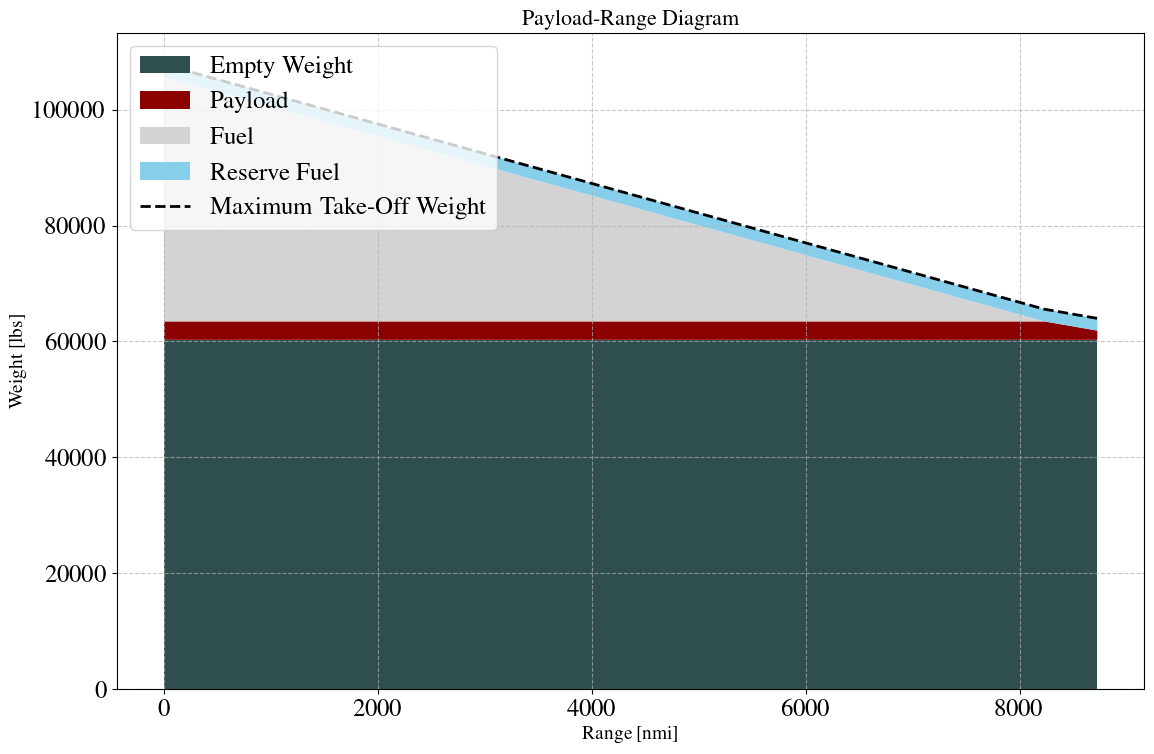


Point A:
  Range: 0.00 nmi
  Payload: 3179.75 lbs
  Fuel: 42217.92 lbs
  Reserve Fuel: 2110.90 lbs
  Empty Weight: 60285.03 lbs
  MTOW: 107793.60 lbs

Point B:
  Range: 8226.73 nmi
  Payload: 3179.75 lbs
  Fuel: 0.00 lbs
  Reserve Fuel: 2110.90 lbs
  Empty Weight: 60285.03 lbs
  MTOW: 65575.68 lbs

Point C:
  Range: 8722.10 nmi
  Payload: 1589.87 lbs
  Fuel: 0.00 lbs
  Reserve Fuel: 2110.90 lbs
  Empty Weight: 60285.03 lbs
  MTOW: 62395.93 lbs


In [53]:
import numpy as np
import matplotlib.pyplot as plt

# Constants for the design
MTOW = 105682.71  # Maximum Takeoff Weight (lbs)
OEW = MTOW-(3179.75 + 42217.93)  # Operating Empty Weight (lbs) (payload+useful fuel)
MFW = 44328.82  # Maximum Fuel Weight (lbs) 
RESERVE_FUEL = 2110.90  # Reserve Fuel (lbs)

# New Payload with 15% cushion
CREW_WEIGHT = 3 * 215  # 3 crew members (2 pilots, 1 flight attendant) at 215 lbs each
PASSENGER_WEIGHT = 8 * 215  # 8 passengers at 215 lbs each
BAGGAGE_WEIGHT = 8 * 50  # 8 passengers with 50 lbs baggage each
BASE_PAYLOAD = CREW_WEIGHT + PASSENGER_WEIGHT + BAGGAGE_WEIGHT
PAYLOAD = BASE_PAYLOAD * 1.15  # Add 15% cushion to account for extra laugagges 

# Updated performance parameters
CT_hr = 0.5466 # TSFC in lb/lbf/hr (cruise)
LbyD = 17.5 #16.7973  # Lift-to-drag ratio 
V_knots = 517 # Cruise speed in knots 

# Breguet Range Function
def breguet_range(Wi, Wf, V, LbyD, CT):
    return (V * LbyD / CT) * np.log(Wi / Wf)  # Range in nmi

# Payload-Range Diagram Function with Stacked Plot
def payload_range_diagram():
    CT = CT_hr  # TSFC in lb/lbf/hr
    V = V_knots  # Speed in knots
    
    # Point A: Max Payload, zero range
    R_A = 0
    Payload_A = PAYLOAD
    Fuel_A = MFW - RESERVE_FUEL  # Non-reserve fuel at zero range
    Reserve_Fuel_A = RESERVE_FUEL
    MTOW_A = OEW + Payload_A + Fuel_A + Reserve_Fuel_A

    # Point B: Max Payload, range with full fuel burned (excluding reserve fuel)
    Wi_B = OEW + PAYLOAD + MFW  # Initial weight (max payload + max fuel)
    Wf_B = OEW + PAYLOAD + RESERVE_FUEL  # Final weight (reserve fuel remains)
    R_B = breguet_range(Wi_B, Wf_B, V, LbyD, CT)
    Payload_B = PAYLOAD
    Fuel_B = 0  # All non-reserve fuel burned
    Reserve_Fuel_B = RESERVE_FUEL
    MTOW_B = Wf_B  # MTOW after fuel burn

    # Point C: Zero Payload, max range
    Wi_C = MTOW
    Wf_C = OEW + RESERVE_FUEL  # Reserve fuel remains
    R_C = breguet_range(Wi_C, Wf_C, V, LbyD, CT)
    Payload_C = 0.5*PAYLOAD
    Fuel_C = 0  # All non-reserve fuel burned
    Reserve_Fuel_C = RESERVE_FUEL
    MTOW_C = Wf_C

    # Data for Stacked Plot
    ranges = np.array([R_A, R_B, R_C])
    empty_weight = np.array([OEW, OEW, OEW])
    payload = np.array([Payload_A, Payload_B, Payload_C])
    fuel = np.array([Fuel_A, Fuel_B, Fuel_C])
    reserve_fuel = np.array([Reserve_Fuel_A, Reserve_Fuel_B, Reserve_Fuel_C])
    mtow = empty_weight + payload + fuel + reserve_fuel

    # Plot the Stacked Area Chart
    plt.figure(figsize=(12, 8))
    plt.stackplot(ranges, empty_weight, payload, fuel, reserve_fuel,
                  labels=['Empty Weight', 'Payload', 'Fuel', 'Reserve Fuel'],
                  colors=['#2F4F4F', '#8B0000', '#D3D3D3', '#87CEEB'])
    plt.plot(ranges, mtow, 'k--', label='Maximum Take-Off Weight', linewidth=2)

    # Add annotations for key points
  #  for i, (r, p) in enumerate(zip(ranges, payload)):
  #      plt.annotate(f'Point {chr(65+i)} ({int(r)}, {int(p)})', 
 #                    (r, p + OEW + reserve_fuel[i] + fuel[i]), 
 #                    textcoords="offset points", xytext=(0, 5), ha='center', fontsize=10, color='black')
#
    # Add annotations for "Maximum Payload Range" and "Maximum Range"
   # plt.annotate('Maximum Payload Range', (R_B, MTOW_B), textcoords="offset points", xytext=(0, 20), fontsize=12, color='black',
   #              arrowprops=dict(arrowstyle="->", color='black'))
    #plt.annotate('Maximum Range', (R_C, MTOW_C), textcoords="offset points", xytext=(-50, 20), fontsize=12, color='black',
  #               arrowprops=dict(arrowstyle="->", color='black'))

    plt.title("Payload-Range Diagram ", fontsize=16)
    plt.xlabel("Range [nmi]", fontsize=14)
    plt.ylabel("Weight [lbs]", fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.show()

    # Return ranges and weight breakdown for each point
    weight_breakdown = {
        'Point A': {'Range': R_A, 'Payload': Payload_A, 'Fuel': Fuel_A, 'Reserve Fuel': Reserve_Fuel_A, 'Empty Weight': OEW,'MTOW': MTOW_A},
        'Point B': {'Range': R_B, 'Payload': Payload_B, 'Fuel': Fuel_B, 'Reserve Fuel': Reserve_Fuel_B, 'Empty Weight': OEW, 'MTOW': MTOW_B},
        'Point C': {'Range': R_C, 'Payload': Payload_C, 'Fuel': Fuel_C, 'Reserve Fuel': Reserve_Fuel_C, 'Empty Weight': OEW, 'MTOW': MTOW_C}
    }
    
    return weight_breakdown

# Run the function and print results
results = payload_range_diagram()
for point, data in results.items():
    print(f"\n{point}:")
    for key, value in data.items():
        print(f"  {key}: {value:.2f} {'nmi' if key == 'Range' else 'lbs'}")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
rho_sl = 1.225  # Air density at sea level (kg/m^3)
T_sl = 144884.78  # Sea-level thrust (N) for the engine
gamma = 1.4     # Ratio of specific heats for air
R = 287.05      # Specific gas constant for air (J/kg·K)
T0 = 288.15     # Sea-level standard temperature (K)
L = 0.0065      # Temperature lapse rate (K/m)
P0 = 101325     # Sea-level pressure (Pa)
g = 9.81        # Gravity (m/s^2)

# Altitude and Mach ranges
altitudes = np.linspace(0, 13000, 50)  # Altitude range: 0 to 12.5 km
mach_numbers = np.linspace(0.2, 0.9, 50)  # Mach range: 0.2 to 0.9

# Function to calculate air density at a given altitude (ISA model)
def air_density(altitude):
    if altitude < 11000:  # Troposphere
        T = T0 - L * altitude
        P = P0 * (1 - L * altitude / T0) ** (g / (R * L))
        rho = P / (R * T)
    else:  # Simplified model for stratosphere
        T = T0 - L * 11000
        P = P0 * (1 - L * 11000 / T0) ** (g / (R * L)) * np.exp(-g * (altitude - 11000) / (R * T))
        rho = P / (R * T)
    return rho

# Function to calculate thrust lapse with altitude and Mach
def thrust_lapse(altitude, mach):
    rho = air_density(altitude)
    thrust = T_sl * (rho / rho_sl) * (1 - 0.1 * mach**2)  # Simplified thrust lapse model
    return max(thrust, 0)  # Thrust cannot be negative

# Calculate thrust over altitude and Mach grid
thrust_values = np.zeros((len(altitudes), len(mach_numbers)))

for i, alt in enumerate(altitudes):
    for j, mach in enumerate(mach_numbers):
        thrust_values[i, j] = thrust_lapse(alt, mach)

# Plot the contour plot
X, Y = np.meshgrid(mach_numbers, altitudes)

plt.figure(figsize=(9, 5))
cp = plt.contour(X, Y, thrust_values, levels=10, colors='black', linestyles='solid')
plt.clabel(cp, inline=True, fontsize=10, fmt="%.0f N")  #  labels to contours
plt.title("Thrust as a Function of Altitude and Mach Number", fontsize=14)
plt.xlabel("Mach Number", fontsize=12)
plt.ylabel("Altitude (m)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


In [55]:
import math
#GUDMONSSUN METHOD WITH FAA VERIFICATION 
# Constants
W =470099.9442762 # N 
T_SL = 177928.86   # N (2 x 20000lbf)
S = 119.05 # m^2 
C_D0 = 0.04230 # From takeoff drag study
C_Lmax = 1.9   # Takeoff config (flaps 20°)
AR = 7.040
e = 0.96618
mu = 0.04
g = 9.81
h_obs = 15.24  # 50 ft as per the regulation 

# Air density function
def air_density(altitude_ft, temperature_c):
    T0 = 288.15
    P0 = 101325
    L = 0.0065
    R = 287.05
    altitude_m = altitude_ft * 0.3048
    temperature_k = temperature_c + 273.15
    T_alt = max(T0 - L * altitude_m, 200.0)
    P_alt = P0 * (T_alt / T0) ** (g / (R * L))
    rho = P_alt / (R * temperature_k)
    return max(rho, 0.1)

# Takeoff performance with Part 25 checks
def takeoff_performance(altitude_ft, temperature_c, wind_speed, slope_deg):
    rho = air_density(altitude_ft, temperature_c)
    
    # Stall speed
    V_stall = math.sqrt(2 * W / (rho * S * C_Lmax))
    
    # Takeoff speeds per Part 25
    V_1 =  1.1 * V_stall  # Simplified V_1 (adjustable)
    V_R = max(1.05 * V_stall, V_1)  # Rotation speed
    V_LOF = 1.15 * V_stall
    V_2 = 1.2 * V_stall  # Takeoff safety speed
    V_GS = V_LOF - wind_speed
    
    # Ground run forces at V_avg
    V_avg = 0.7 * V_LOF
    k = 1 / (math.pi * e * AR)
    C_L_avg = 0.3 * C_Lmax
    C_D_avg = C_D0 + k * C_L_avg**2
    q_avg = 0.5 * rho * V_avg**2
    L = q_avg * S * C_L_avg
    D = q_avg * S * C_D_avg
    T_avg = 0.7 * T_SL
    theta = math.radians(slope_deg)
    W_eff = W * math.cos(theta)
    F_slope = W * math.sin(theta)
    
    # Acceleration and S_G
    a = (T_avg - D - mu * (W_eff - L) - F_slope) / (W / g)
    S_G = (V_GS**2) / (2 * a)
    
    # Rotation distantance
    S_R = V_R *3 # 3 seconds rotation time 

    # Airborne distance at V_LOF (all engines)
    q_LOF = 0.5 * rho * V_LOF**2
    D_LOF = q_LOF * S * C_D_avg
    gamma_LOF = (T_avg - D_LOF) / W
    S_A = h_obs / math.tan(gamma_LOF)
    S_TO = S_G + S_A +S_R
    
    # OEI climb check at V_2. ONE ENGINE INOPERABLE
    T_OEI = 0.5 * T_SL  # One engine out
    q_2 = 0.5 * rho * V_2**2
    D_2 = q_2 * S * C_D_avg
    gamma_OEI = (T_OEI - D_2) / W
    gamma_OEI_percent = gamma_OEI * 100
    
    return S_TO, V_stall, V_1, V_R, V_LOF, V_2, V_GS, gamma_OEI_percent

# Missions
missions = {
    "Passenger Mission": {"altitude_ft": 800, "temperature_c": 15, "wind_speed": 0, "slope_deg": 0},
    "Aspen Economic Mission": {"altitude_ft": 7820, "temperature_c": -7, "wind_speed": 5, "slope_deg": 0.5},
    "Napa Economic Mission": {"altitude_ft": 7316, "temperature_c": 24, "wind_speed": -3, "slope_deg": -0.3},
}

# Results with Part 25 validation
for mission, params in missions.items():
    S_TO, V_stall, V_1, V_R, V_LOF, V_2, V_GS, gamma_OEI = takeoff_performance(
        params["altitude_ft"], params["temperature_c"], params["wind_speed"], params["slope_deg"]
    )
    print(f"{mission}:")
    print(f"  V_stall: {V_stall:.2f} m/s ({V_stall / 0.514444:.2f} knots)")
    print(f"  V_1: {V_1:.2f} m/s ({V_1 / 0.514444:.2f} knots)")
    print(f"  V_R: {V_R:.2f} m/s ({V_R / 0.514444:.2f} knots)")
    print(f"  V_LOF: {V_LOF:.2f} m/s ({V_LOF / 0.514444:.2f} knots)")
    print(f"  V_2: {V_2:.2f} m/s ({V_2 / 0.514444:.2f} knots)")
    print(f"  V_GS: {V_GS:.2f} m/s ({V_GS / 0.514444:.2f} knots)")
    print(f"  Takeoff Distance: {S_TO:.2f} m ({S_TO / 0.3048:.2f} ft)")
    print(f"  OEI Climb Gradient at V_2: {gamma_OEI:.2f}%")
    if gamma_OEI >= 2.4:
        print("  ✅ Meets Part 25 OEI climb requirement (≥2.4%)")
    else:
        print("  ⚠️ Below Part 25 OEI climb requirement (2.4%)")
    print()

Passenger Mission:
  V_stall: 59.10 m/s (114.88 knots)
  V_1: 65.01 m/s (126.37 knots)
  V_R: 65.01 m/s (126.37 knots)
  V_LOF: 67.97 m/s (132.12 knots)
  V_2: 70.92 m/s (137.86 knots)
  V_GS: 67.97 m/s (132.12 knots)
  Takeoff Distance: 1366.46 m (4483.13 ft)
  OEI Climb Gradient at V_2: 14.57%
  ✅ Meets Part 25 OEI climb requirement (≥2.4%)

Aspen Economic Mission:
  V_stall: 64.74 m/s (125.84 knots)
  V_1: 71.21 m/s (138.42 knots)
  V_R: 71.21 m/s (138.42 knots)
  V_LOF: 74.45 m/s (144.71 knots)
  V_2: 77.68 m/s (151.01 knots)
  V_GS: 69.45 m/s (134.99 knots)
  Takeoff Distance: 1482.97 m (4865.37 ft)
  OEI Climb Gradient at V_2: 14.57%
  ✅ Meets Part 25 OEI climb requirement (≥2.4%)

Napa Economic Mission:
  V_stall: 67.75 m/s (131.69 knots)
  V_1: 74.52 m/s (144.86 knots)
  V_R: 74.52 m/s (144.86 knots)
  V_LOF: 77.91 m/s (151.45 knots)
  V_2: 81.30 m/s (158.03 knots)
  V_GS: 80.91 m/s (157.28 knots)
  Takeoff Distance: 1818.37 m (5965.77 ft)
  OEI Climb Gradient at V_2: 14.57%
  

In [56]:
#More accurate result 
import math
# Constants
g = 9.81  # Gravity (m/s²)
mu = 0.16  # Wheel braking coefficient
h_obs = 15.24  # 50 ft obstacle height in meters
n_flare = 1.2  # Load factor during flare

def air_density(altitude_ft, temperature_c):
    """Computes air density using ISA model with improved accuracy."""
    T0 = 288.15  # K
    P0 = 101325  # Pa
    L = 0.0065  # K/m
    R = 287.05  # J/(kg*K)
    altitude_m = altitude_ft * 0.3048
    temperature_k = temperature_c + 273.15
    
    if altitude_m < 11000:  # Troposphere
        T_alt = T0 - L * altitude_m
        P_alt = P0 * (T_alt / T0) ** (g / (L * R))
    else:
        T_alt = 216.65  # Constant in lower stratosphere
        P_alt = P0 * (0.22336 * math.exp(-g * (altitude_m - 11000) / (R * T_alt)))
    
    rho = P_alt / (R * T_alt)
    return max(rho, 0.1)

def landing_distance(W, S, C_Lmax, C_D0, AR, e, altitude_ft, temperature_c, wind_speed):
    """Computes total landing distance with refined aerodynamics."""
    rho = air_density(altitude_ft, temperature_c)
    
    # Stall Speed Calculation
    V_stall = math.sqrt((2 * W) / (rho * S * C_Lmax))
    V_TD = 1.05 * V_stall  # Touchdown speed
    V_GS = max(V_TD - wind_speed, 1)  # Ensure positive ground speed
    
    # Flare Distance Calculation 
    R_flare = (V_TD ** 2) / (g * (n_flare - 1))
    theta_flare = math.atan(h_obs / R_flare)  # Improved flare angle
    S_flare = R_flare * theta_flare
    S_approach = h_obs / math.tan(math.radians(3))  # 3° glide slope
    S_A = S_approach + S_flare  # Total airborne distance
    
    # Aerodynamic Parameters
    k = 1 / (math.pi * e * AR)
    C_L_avg = 0.75 * C_Lmax
    C_D_avg = C_D0 + k * C_L_avg ** 2
    q_TD = 0.5 * rho * V_TD ** 2
    L_avg = q_TD * S * C_L_avg
    D_avg = q_TD * S * C_D_avg
    
    # Deceleration with Aerodynamic Braking & Wheel Braking
    C_D_spoilers = 0.1  # Assumed spoiler drag increase
    D_spoilers = q_TD * S * C_D_spoilers
    a = g * (- (D_avg + D_spoilers) / W - mu * (1 - L_avg / W))
    S_G = (V_GS ** 2) / (2 * abs(a))
    
    # Total Landing Distance
    S_L = S_A + S_G
    
    return S_L, S_A, S_G, V_stall, V_TD, V_GS

# Aircraft Data
W_landing_lb = 61533.30 + 2110.90 # (Wd +Reserve)
W = 4.4482 *W_landing_lb  # N (New weight)
S = 119.05  # m^2
C_Lmax = 2.1  # Flaps 40°
C_D0 =  0.04919   # Landing drag coefficient
AR = 7.040  # Aspect Ratio
e = 0.966184  # Oswald efficiency factor

# Landing Missions
missions = {
    "Passenger Mission": {"altitude_ft": 800, "temperature_c": 15, "wind_speed": 0},
    "Aspen Economic Mission": {"altitude_ft": 7820, "temperature_c": -7, "wind_speed": 5},
    "Napa Economic Mission": {"altitude_ft": 7316, "temperature_c": 24, "wind_speed": -3},
}

# Compute Landing Distances
for mission, params in missions.items():
    S_L, S_A, S_G, V_stall, V_TD, V_GS = landing_distance(
        W, S, C_Lmax, C_D0, AR, e, params["altitude_ft"], params["temperature_c"], params["wind_speed"]
    )
    print(f"{mission}:")
    print(f"  Stall Speed (V_stall): {V_stall:.2f} m/s ({V_stall / 0.514444:.2f} knots)")
    print(f"  Touchdown Speed (V_TD): {V_TD:.2f} m/s ({V_TD / 0.514444:.2f} knots)")
    print(f"  Ground Speed (V_GS): {V_GS:.2f} m/s ({V_GS / 0.514444:.2f} knots)")
    print(f"  Airborne Distance (S_A): {S_A:.2f} m ({S_A / 0.3048:.2f} ft)")
    print(f"  Ground Roll Distance (S_G): {S_G:.2f} m ({S_G / 0.3048:.2f} ft)")
    print(f"  Total Landing Distance (S_L): {S_L:.2f} m ({S_L / 0.3048:.2f} ft)")
    print()


Passenger Mission:
  Stall Speed (V_stall): 43.51 m/s (84.57 knots)
  Touchdown Speed (V_TD): 45.68 m/s (88.80 knots)
  Ground Speed (V_GS): 45.68 m/s (88.80 knots)
  Airborne Distance (S_A): 306.04 m (1004.05 ft)
  Ground Roll Distance (S_G): 636.98 m (2089.82 ft)
  Total Landing Distance (S_L): 943.01 m (3093.88 ft)

Aspen Economic Mission:
  Stall Speed (V_stall): 48.37 m/s (94.02 knots)
  Touchdown Speed (V_TD): 50.78 m/s (98.72 knots)
  Ground Speed (V_GS): 45.78 m/s (89.00 knots)
  Airborne Distance (S_A): 306.04 m (1004.05 ft)
  Ground Roll Distance (S_G): 639.87 m (2099.32 ft)
  Total Landing Distance (S_L): 945.91 m (3103.37 ft)

Napa Economic Mission:
  Stall Speed (V_stall): 47.99 m/s (93.29 knots)
  Touchdown Speed (V_TD): 50.39 m/s (97.95 knots)
  Ground Speed (V_GS): 53.39 m/s (103.78 knots)
  Airborne Distance (S_A): 306.04 m (1004.05 ft)
  Ground Roll Distance (S_G): 870.14 m (2854.80 ft)
  Total Landing Distance (S_L): 1176.18 m (3858.86 ft)



In [ ]:
import matplotlib.pyplot as plt

# Data
flight_segments = ["Take-off", "Climb", "Cruise", "Landing"]
adjusted_thrust = [33606.51, 24237.72, 9586.21, 8717.35]


plt.rcParams["font.family"] = "Times New Roman"

# Create bar chart
plt.figure(figsize=(8, 6), dpi=300)
plt.bar(flight_segments, adjusted_thrust, color=['gold', 'lightblue', 'lightcoral', 'lightgreen'])

# Labels and title
plt.xlabel("Flight Segment", fontsize=18)  # Increase X-axis label font
plt.ylabel("Adjusted Thrust (lbf)", fontsize=18)  # Increase Y-axis label font
#plt.title("Adjusted Thrust Across Flight Segments", fontsize=16)  # Increase title font

# Increase tick label font size for both axes
plt.xticks(fontsize=18)  # Increase font size for X-axis numbers
plt.yticks(fontsize=18)  # Increase font size for Y-axis numbers

# Grid for better readability
#plt.grid(axis="y", linestyle="--", alpha=0.7)

# Save the figure
plt.savefig("adjusted_thrust_bar_chart.png", dpi=300, bbox_inches="tight")

# Show the chart
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Data
labels = ['Takeoff', 'Climb', 'Cruise', 'Landing']
fuel_burn_lbs = [613.58, 2186.60, 29541.57, 1066.86]
colors = ['gold', 'lightblue', 'lightcoral', 'lightgreen']

# Set font size globally
plt.rcParams.update({'font.size': 14})  # Increases font size for all elements

# Create pie chart
plt.figure(figsize=(8, 6), dpi=300)
plt.pie(fuel_burn_lbs, labels=labels, autopct='%1.1f%%', colors=colors, 
        startangle=140, shadow=False, textprops={'fontsize': 16})  # Increase label font size

# Title with larger font
#plt.title('Fuel Burn Distribution Across Flight Phases', fontsize=18)

# Show the chart
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({
    "text.usetex": True,              # Use LaTeX for all text rendering
    "font.family": "serif",           # Use LaTeX's default font family
    "font.serif": ["Times"],# Use Computer Modern for a LaTeX-like font
    "font.size": 22,                  # Global font size to match LaTeX
    "axes.titlesize": 22,             # Font size for title
    "axes.labelsize": 20,             # Font size for axis labels
    "xtick.labelsize": 18,            # Font size for x-axis ticks
    "ytick.labelsize": 18,            # Font size for y-axis ticks
    "legend.fontsize": 18             # Font size for legend
})

def m_in_ft(value):
    return value / 0.3048

def m_in_ft_vector(value):
    for i in range(len(value)):
        value[i] = value[i] / 0.3048
    return value
# Constants
g = 9.81  # m/s^2
m = 48126.96 # kg
rho = 0.3 # false
CL= 0.3 #false
CL_max = 0.3 #false
S = 120.24 / 0.0929 #m^2
MTOW = m*g
# Define range of Equivalent Airspeed (EAS) and load factors
V_max = 210 # m/s
eas = np.linspace(1, V_max, V_max)  # m/s
load_factors = [1.25, 1.5,1.75, 2, 2.25, 2.5, 3, 3.5]  # n_z

# Calculate turn radius and turn rate for each combination
plt.figure(figsize=(10, 6),dpi=300)
compt = 0
for n_z in load_factors:
    omega = np.zeros_like(eas)
    for i in range(len(eas)):
        omega[i] = (g * np.sqrt(n_z**2 - 1)) / eas[i]
        if(n_z == 2.5):
            if(compt == 0):
                lim = i
                omega_25 = np.zeros(len(eas)-lim)
                V_25 = np.zeros(len(eas)-lim)
                compt = 1
            omega_25[i-lim] = omega[i]
            V_25[i-lim] = eas[i]
        
    plt.plot(m_in_ft(eas), omega, label=f'n = {n_z:.2f}')
  
R_text=np.zeros(0)      
for R in [50,100,150, 200, 300, 400, 500, 750, 1000]:
    R_text = np.append(R_text, R)
    omega_R = np.zeros_like(eas)
    for i in range(len(eas)):
        omega[i] = (g * np.sqrt(n_z**2 - 1)) / eas[i]
        omega_R[i] = eas[i] / R
        
    plt.plot(m_in_ft(eas), omega_R, color = 'black')
    
    
n_range = np.arange(1.00001, 2.5, 0.001 )
R1 = np.zeros_like(n_range)
V_min = np.zeros_like(n_range)
omega_Vmin = np.zeros_like(n_range)
for i in range(len(n_range)):
    V_min[i] = np.sqrt((2 * n_range[i] * MTOW) / (rho * S * CL_max))
    R1[i] = np.sqrt(m**2 / ((0.5 * rho * CL * S)**2 - (m * g / (V_min[i]**2))**2))
    omega_Vmin[i] = V_min[i] / R1[i]
    
omega_2 = np.zeros(int(V_max - V_min[-1]))
V_2 = np.linspace(V_min[-1], V_max , int(V_max - V_min[-1]))

for i in range(len(V_2)):
    omega_2[i] = (g * np.sqrt(2.5**2 - 1)) / V_2[i]
    
plt.plot(m_in_ft(V_min), omega_Vmin, color = 'red', linewidth = '3')
plt.plot(m_in_ft(V_2), omega_2, color = 'red', linewidth = '3')

R_text = m_in_ft_vector(R_text)
print(R_text[0])
# plt.text(32, 0.58, f"$R = {int(R_text[0])}ft$", fontsize=14, color="black")
# plt.text(128, 0.58, f"$R = {int(R_text[1])}ft$", fontsize=14, color="black")
# plt.text(222, 0.58, f"$R = {int(R_text[2])}ft$", fontsize=14, color="black")
# plt.text(316, 0.58, f"$R = {int(R_text[3])}ft$", fontsize=14, color="black")
# plt.text(506, 0.58, f"$R = {int(R_text[4])}ft$", fontsize=14, color="black")
# plt.text(525, 0.455, f"$R = {int(R_text[5])}ft$", fontsize=14, color="black")
# plt.text(525, 0.367, f"$R = {int(R_text[6])}ft$", fontsize=14, color="black")
# plt.text(525, 0.247, f"$R = {int(R_text[7])}ft$", fontsize=14, color="black")
# plt.text(525, 0.185, f"$R = {int(R_text[8])}ft$", fontsize=14, color="black")


plt.text(13, 0.575, f"$R = {int(R_text[0])}ft$", fontsize=18, color="black")
plt.text(108, 0.575, f"$R = {int(R_text[1])}ft$", fontsize=18, color="black")
plt.text(202, 0.575, f"$R = {int(R_text[2])}ft$", fontsize=18, color="black")
plt.text(300, 0.575, f"$R = {int(R_text[3])}ft$", fontsize=18, color="black")
plt.text(485, 0.575, f"$R = {int(R_text[4])}ft$", fontsize=18, color="black")
plt.text(505, 0.455, f"$R = {int(R_text[5])}ft$", fontsize=18, color="black")
plt.text(505, 0.367, f"$R = {int(R_text[6])}ft$", fontsize=18, color="black")
plt.text(505, 0.247, f"$R = {int(R_text[7])}ft$", fontsize=18, color="black")
plt.text(505, 0.185, f"$R = {int(R_text[8])}ft$", fontsize=18, color="black")



plt.xlim(0,600)
plt.ylim(0,0.6)
plt.xlabel('Equivalent airspeed [ft/s]')
plt.ylabel('Turn rate [rad/s]')
plt.legend(loc='lower left')
#plt.savefig("/Users/louisbelboom/Documents/PI/figure/Turn_rate.pdf", format="pdf", dpi=300, bbox_inches="tight")
plt.show()

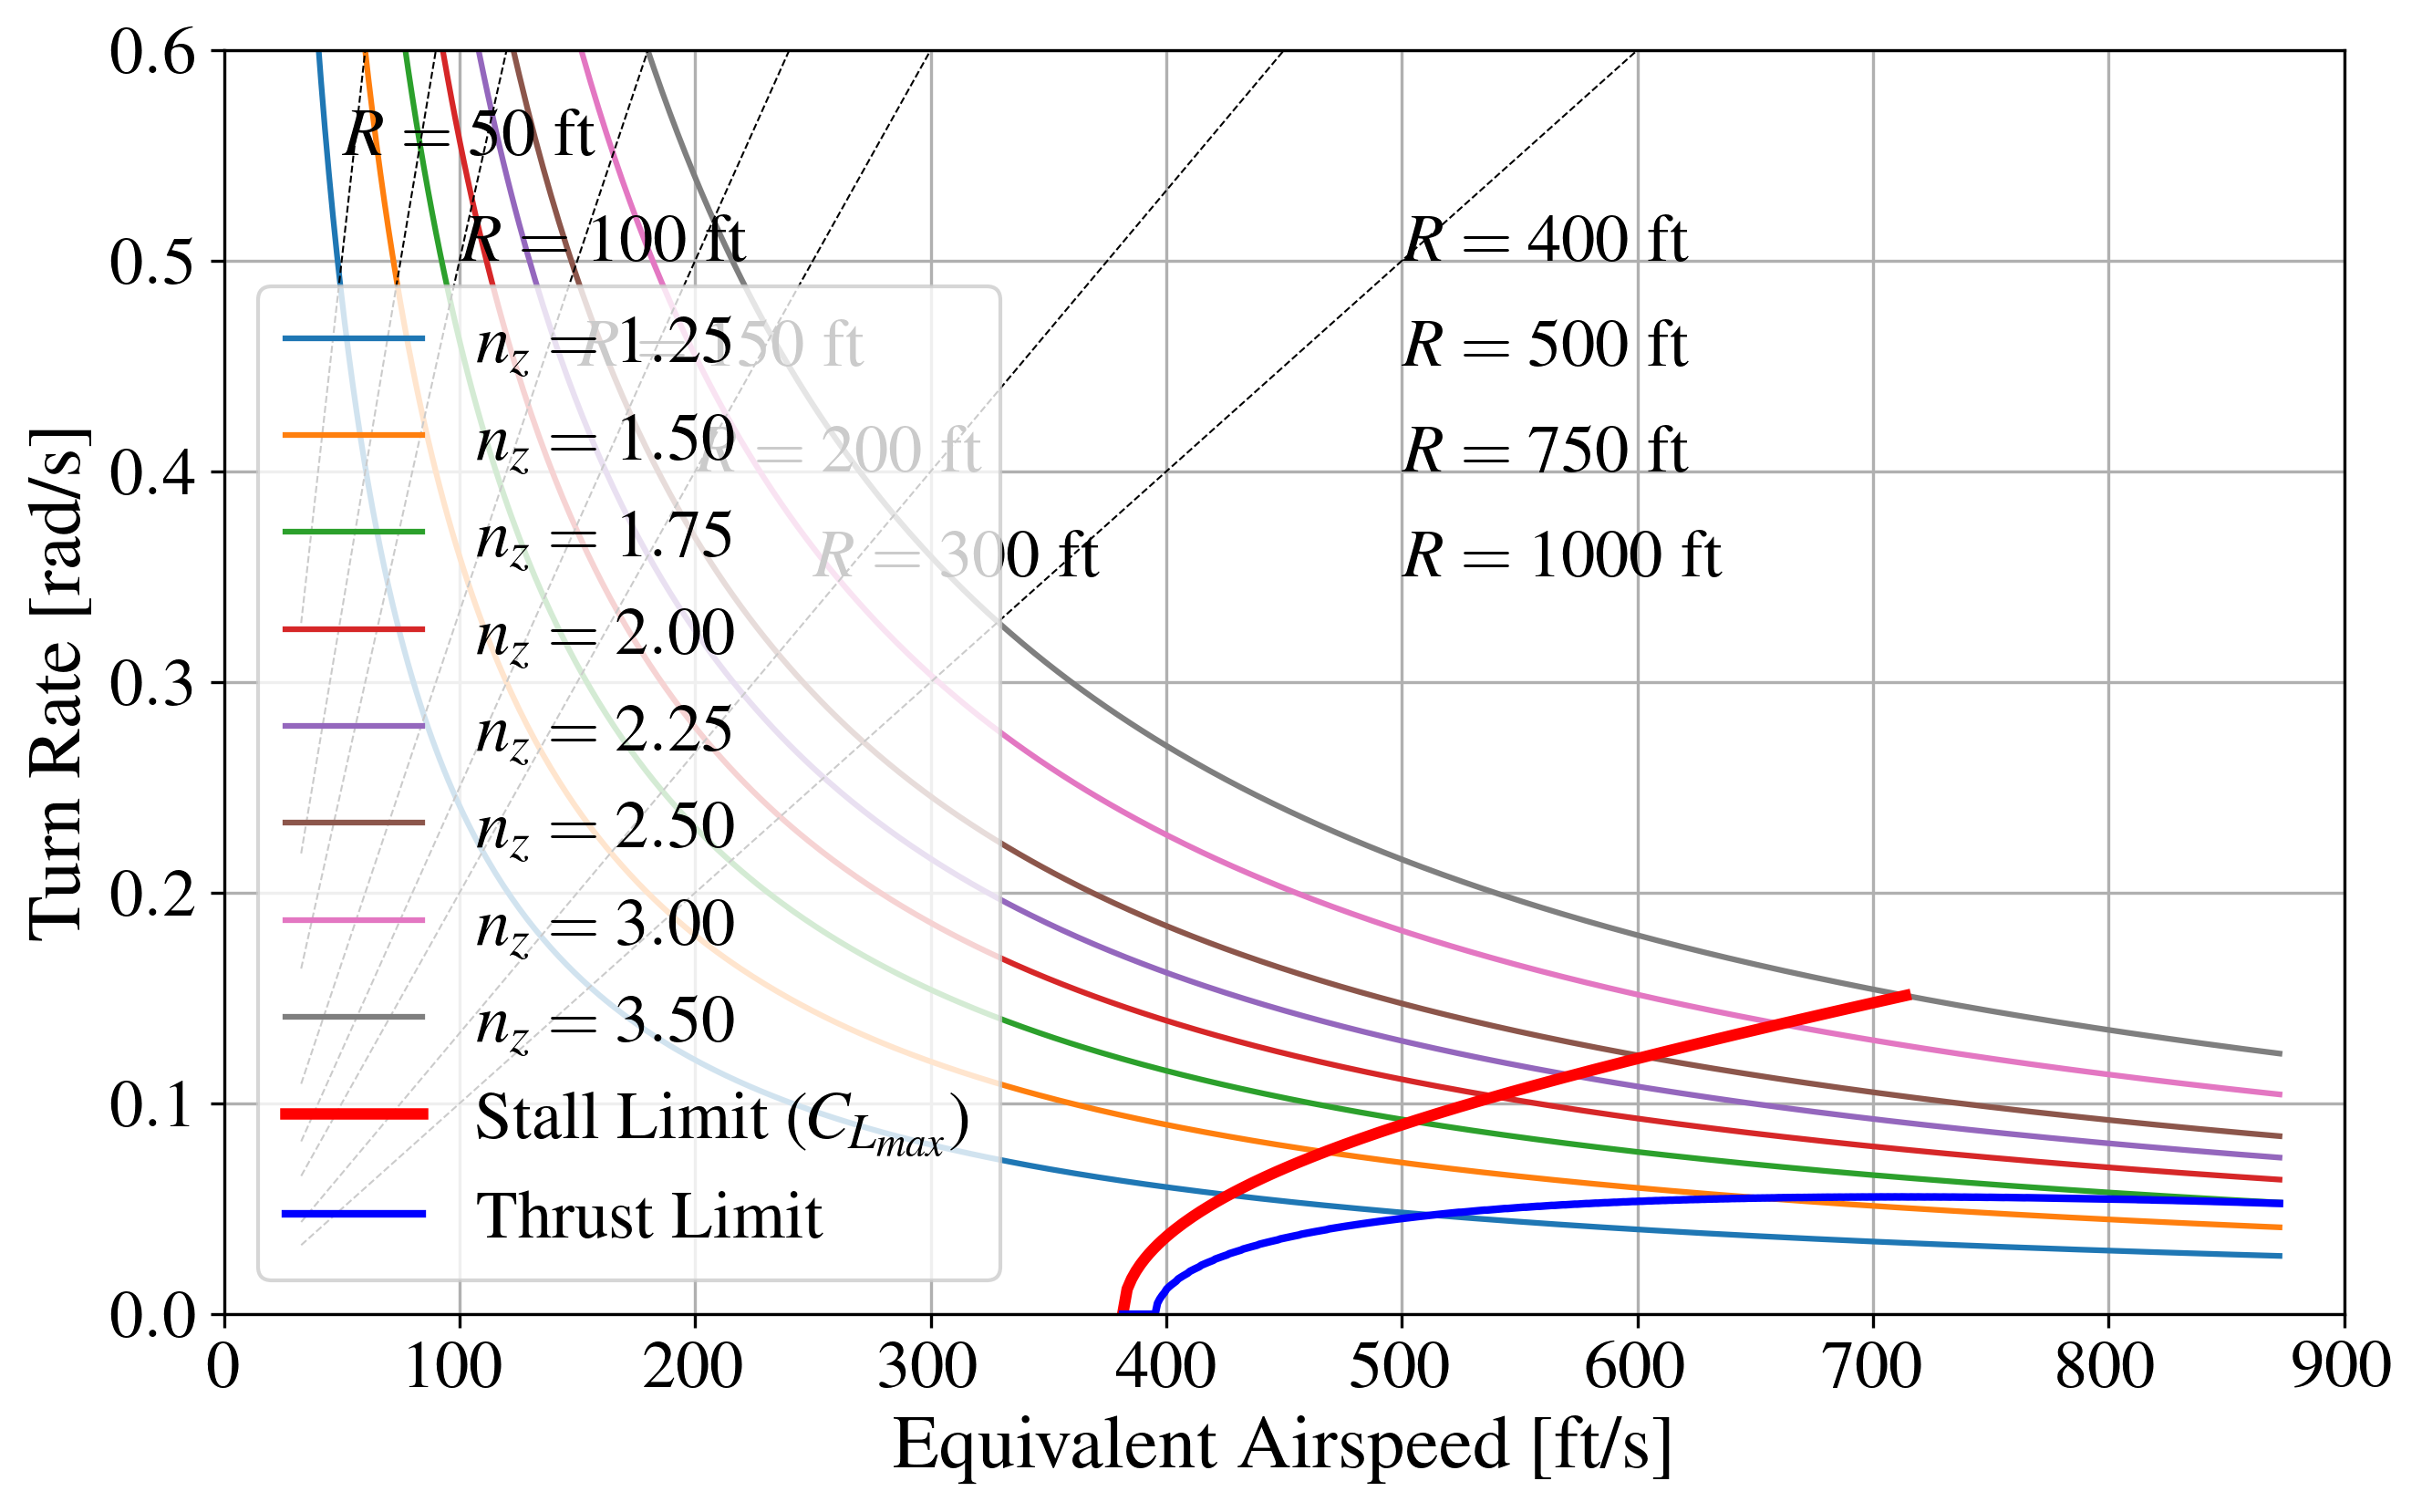

Air Density at 41,000 ft: 0.287 kg/m^3
Stall Speed at n_z = 1: 116.29 m/s (381.54 ft/s)


In [57]:
import numpy as np
import matplotlib.pyplot as plt
#TURN RATE 
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Times"],
    "font.size": 22,
    "axes.titlesize": 22,
    "axes.labelsize": 20,
    "xtick.labelsize": 18,
    "ytick.labelsize": 18,
    "legend.fontsize": 18
})

# Conversion
def m_to_ft(value):
    return value / 0.3048

# Air density function (ISA model)
def air_density(altitude_ft, temperature_c):
    T0 = 288.15
    P0 = 101325
    L = 0.0065
    R = 287.05
    altitude_m = altitude_ft * 0.3048
    temperature_k = temperature_c + 273.15
    if altitude_m <= 11000:
        T_alt = T0 - L * altitude_m
        P_alt = P0 * (T_alt / T0) ** (9.81 / (L * R))
    else:
        T_alt = 216.65
        P_alt = P0 * (216.65 / T0) ** (9.81 / (L * R)) * np.exp(-9.81 * (altitude_m - 11000) / (R * 216.65))
    rho = P_alt / (R * temperature_k)
    return max(rho, 0.1)

# Constants
g = 9.81
W = 439331.37#392635.58  # Cruise weight
m = W / g
S = 119.05
C_L_max = 1.9
T_SL = 177928.87
V_max = 265.97  # 517 knots
a_sound = 295.0  # Speed of sound at 41,000 ft
AR = 7.040
e = 0.966184
C_D0 = 0.01210

# Cruise conditions
rho = air_density(41000, -56.5)

# EAS and load factors
eas = np.linspace(10, V_max, 500)
load_factors = [1.25, 1.5, 1.75, 2, 2.25, 2.5, 3, 3.5]

# Turn rate plot
plt.figure(figsize=(10, 6), dpi=300)
for n_z in load_factors:
    omega = g * np.sqrt(n_z**2 - 1) / eas
    plt.plot(m_to_ft(eas), omega, label=f'$n_z = {n_z:.2f}$')

# Constant radius lines
R_values = [50, 100, 150, 200, 300, 400, 500, 750, 1000]
R_text = np.array(R_values)
for R in R_values:
    R_m = R * 0.3048
    omega_R = eas / R_m
    plt.plot(m_to_ft(eas), omega_R, 'k--', linewidth=0.5)

# Stall boundary
n_range = np.arange(1.0, 3.51, 0.01)
V_stall = np.sqrt(2 * n_range * W / (rho * S * C_L_max))
omega_stall = g * np.sqrt(n_range**2 - 1) / V_stall
plt.plot(m_to_ft(V_stall), omega_stall, 'r-', linewidth=3, label='Stall Limit ($C_{L_{max}}$)')

# Thrust-limited boundary (improved iteration)
V_thrust = np.linspace(V_stall[0], V_max, 500)
omega_thrust = []
for V in V_thrust:
    q = 0.5 * rho * V**2
    T = T_SL * (rho / 1.225) * (1 - 0.1 * V / a_sound)  # relaxed thrust  decay
    # Iterate n_z to find T = D
    n_z = 1.0
    step = 0.001  # Smaller step for better convergence
    while n_z <= 3.5:
        C_L = min(n_z * W / (q * S), C_L_max)
        C_D = C_D0 + (C_L**2) / (np.pi * e * AR)
        D = q * S * C_D
        if abs(T - D) < 700 or T < D:  # More lenient convergence
            break
        n_z += step
    if n_z >= 1 and n_z <= 3.5:
        omega_thrust.append(g * np.sqrt(n_z**2 - 1) / V)
    else:
        omega_thrust.append(0)

plt.plot(m_to_ft(V_thrust), omega_thrust, 'b-', linewidth=2, label='Thrust Limit')

# Dynamic radius label positioning
x_base = 50
y_base = 0.55
for i, R in enumerate(R_text):
    x_pos = x_base + i * 50
    y_pos = y_base - i * 0.05
    if i >= 5:
        x_pos = 500
        y_pos = y_base - (i - 4) * 0.05
    plt.text(x_pos, y_pos, r"$R = {}\ \mathrm{{ft}}$".format(int(R)), fontsize=18, color="black")

plt.xlim(0, 900)
plt.ylim(0, 0.6)
plt.xlabel('Equivalent Airspeed [ft/s]')
plt.ylabel('Turn Rate [rad/s]')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

print(f"Air Density at 41,000 ft: {rho:.3f} kg/m^3")
print(f"Stall Speed at n_z = 1: {V_stall[0]:.2f} m/s ({m_to_ft(V_stall[0]):.2f} ft/s)")

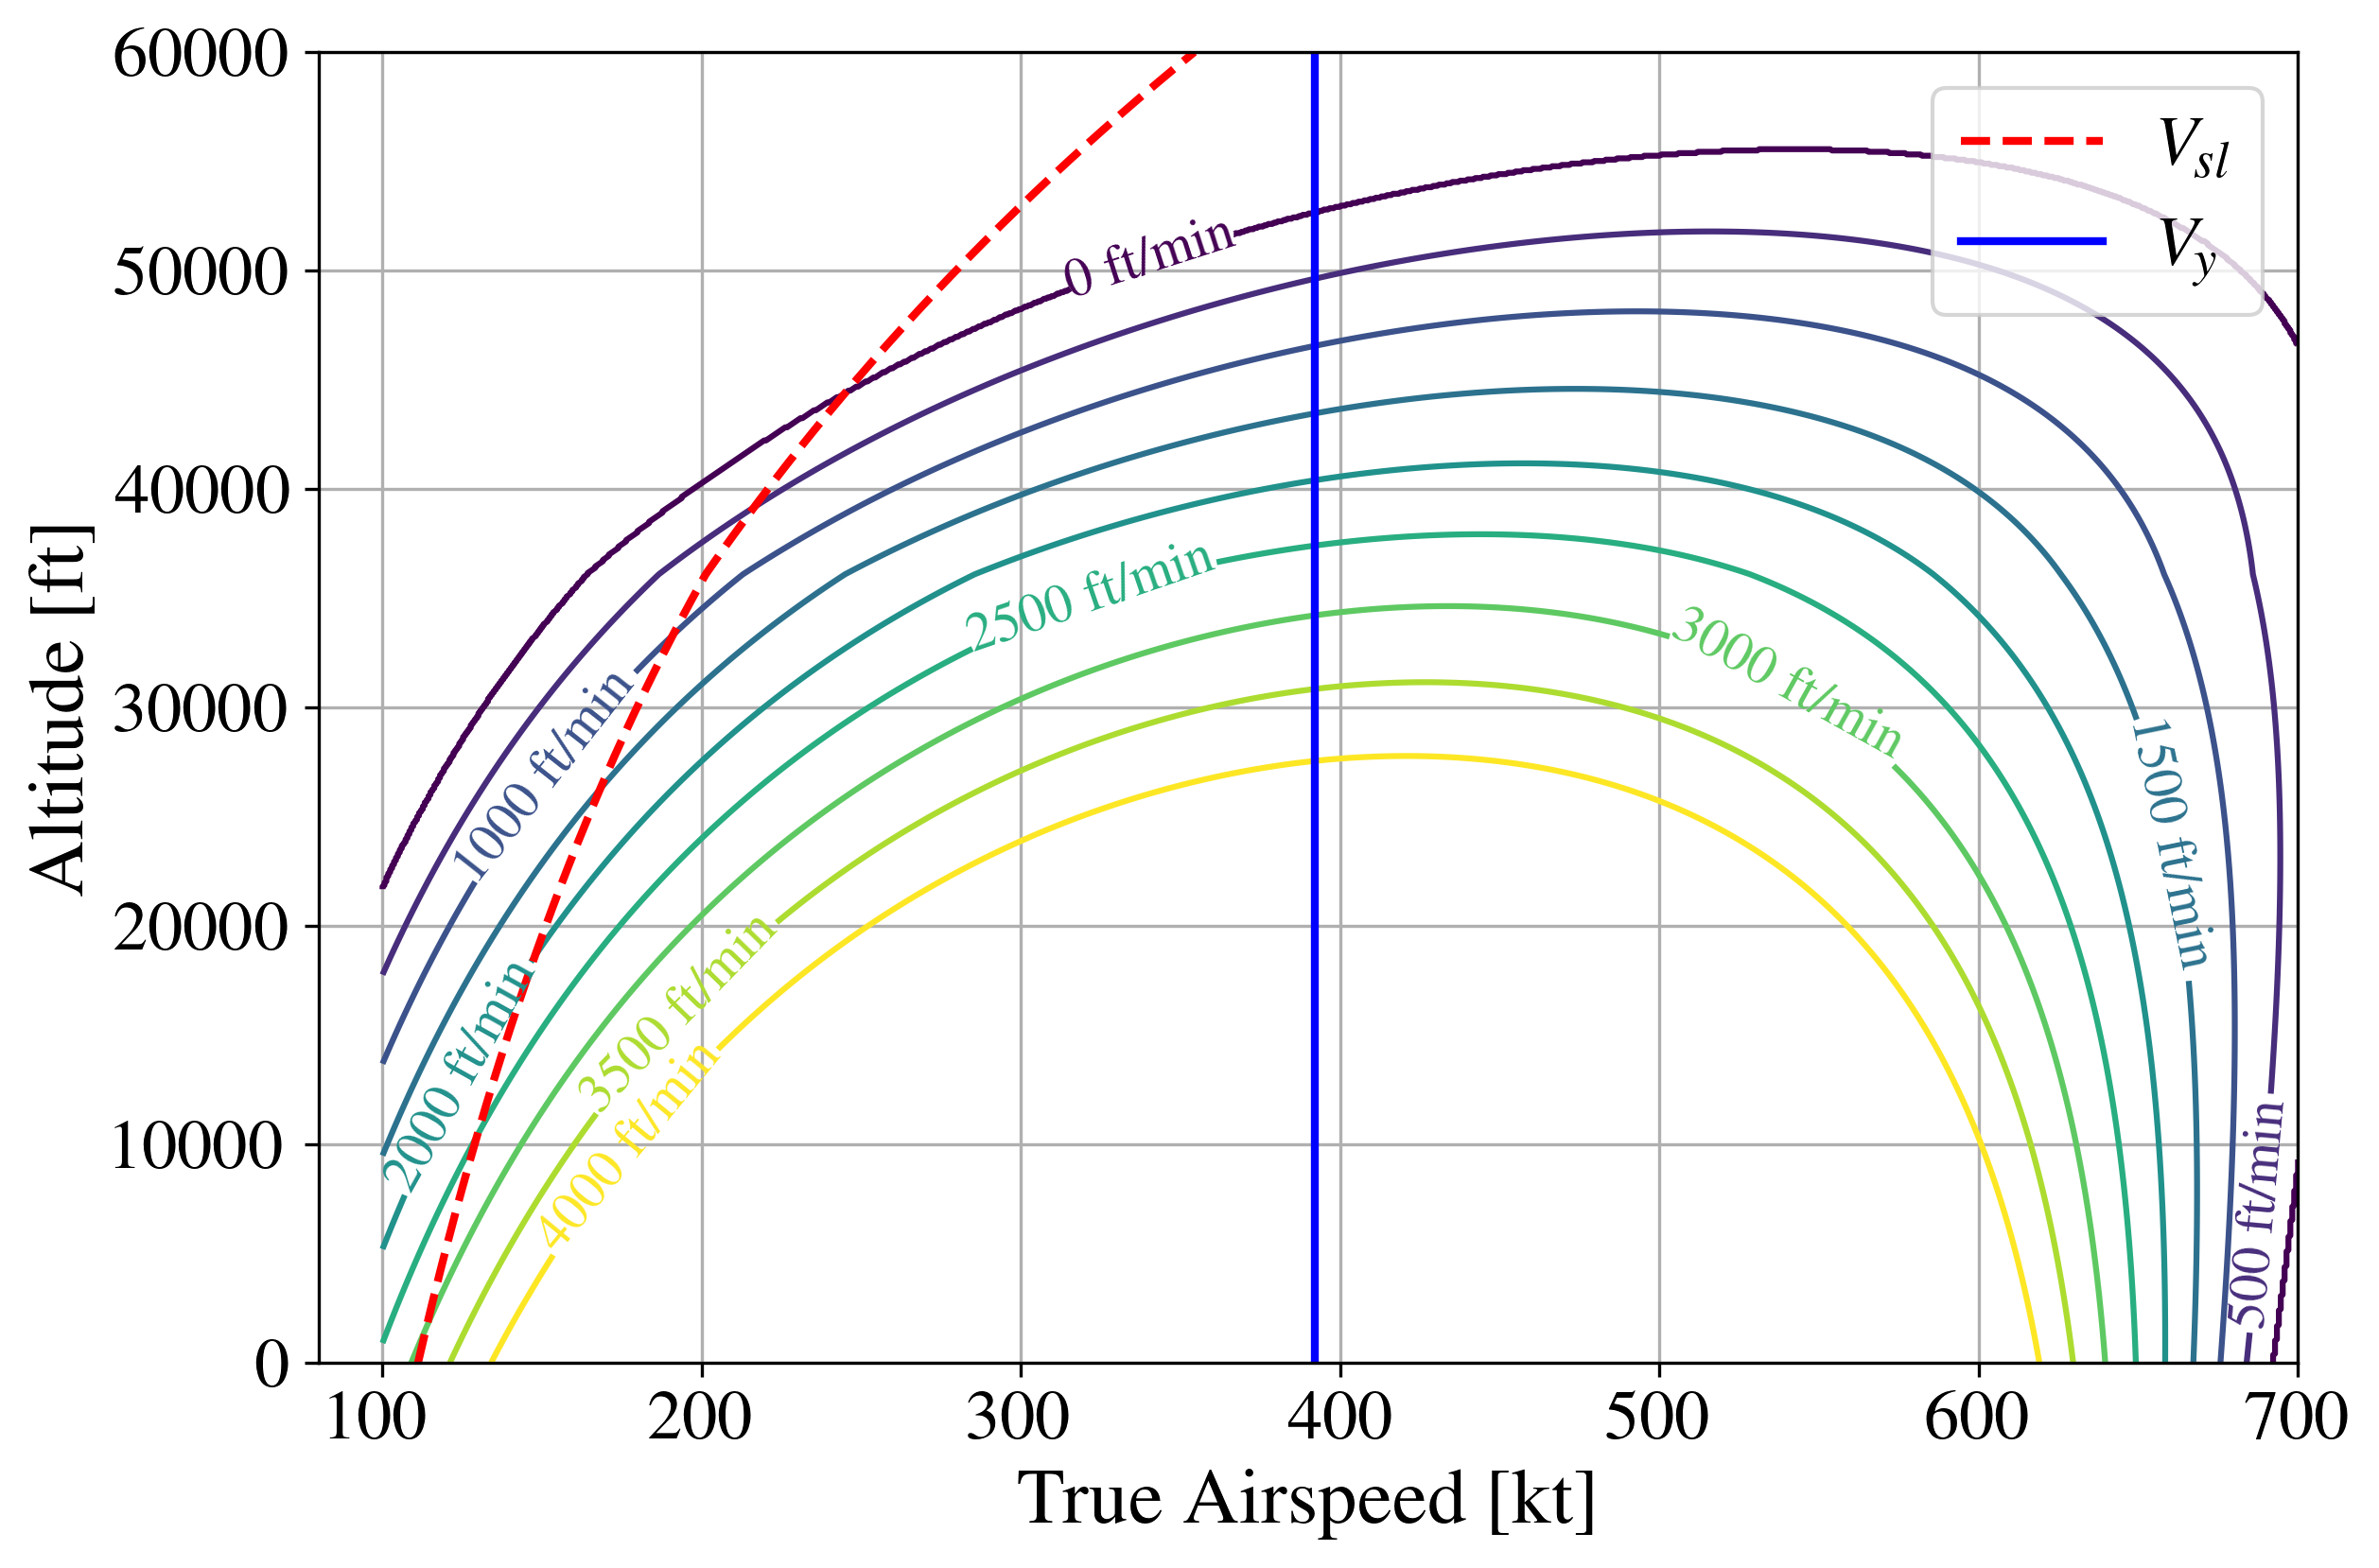

Stall Speed at Sea Level: 111.11 knots
Best Climb Speed (Vy) at Sea Level: 391.89 knots
Service Ceiling: 54775 ft
Time to Climb to 41,000 ft: 9.17 minutes


In [58]:
import numpy as np
import matplotlib.pyplot as plt
# RATE OF CLIMB 
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Times"],
    "font.size": 22,
    "axes.titlesize": 22,
    "axes.labelsize": 20,
    "xtick.labelsize": 18,
    "ytick.labelsize": 18,
    "legend.fontsize": 18
})

# Air density function (ISA model)
R = 287.05
gamma = 1.4
T_0 = 288.15
rho_0 = 1.225
g = 9.81
L = 0.0065
p_0 = 101325

def air_density_ft(altitude):
    altitude = altitude * 0.3048
    if altitude <= 11000:
        T = T_0 - L * altitude
        p = p_0 * (T / 288.15) ** 5.2561
    else:
        T = 216.65
        p = 22632 * np.exp(-9.81 * (altitude - 11000) / (287.05 * T))
    rho = p / (287.05 * T)
    return rho, T, p

# Aircraft & Performance Parameters
W_climb_start = 101772.14 * 4.44822
W_cruise = 98760.25 * 4.44822
S = 119.05
T0 = 2 * 20000 * 4.44822
A = 7.040
e = 0.966184
CL_max = 1.9

altitudes = np.linspace(0, 60000, 1000)
airspeeds_knots = np.linspace(100, 700, 1000)
ROC = np.zeros((len(altitudes), len(airspeeds_knots)))
Vs_alt = np.zeros(len(altitudes))
W_alt = np.zeros(len(altitudes))

# Compute Rate of Climb (ROC)
for i, alt in enumerate(altitudes):
    rho, T, _ = air_density_ft(alt)
    a = np.sqrt(gamma * R * T)
    W = W_climb_start - (alt / 41000) * (W_climb_start - W_cruise)
    W_alt[i] = W
    Vs = np.sqrt((2 * W) / (rho * S * CL_max))
    Vs_alt[i] = Vs * 1.94384
   # if alt <= 5000:
   #     C_D0 = 0.04203 + (0.01669 - 0.04203) * (alt / 5000)
   # elif alt <= 41000:
   #     C_D0 = 0.01669 + (0.01642 - 0.01669) * ((alt - 5000) / 36000)
  #  else:
   #     C_D0 = 0.01642

    for j, tas_knots in enumerate(airspeeds_knots):
        V = tas_knots * 0.514444
        Mach = V / a
        T_alt = T0 * (rho / rho_0) ** 0.8
        T_available = T_alt * (1 - 0.35 * Mach)
        C_L = (2 * W) / (rho * V**2 * S)
        C_D = C_D0 + (C_L**2) / (np.pi * A * e)
        D = 0.5 * rho * V**2 * S * C_D
        excess_thrust = T_available - D
        roc_ms = V * excess_thrust / W
        roc_ft_min = roc_ms * 3.28084 * 60
        ROC[i, j] = max(roc_ft_min, 0)

# compute Vy at sea level and service ceiling
Vy_sea_level = 0
max_ROC = 0
service_ceiling = 0
for i, alt in enumerate(altitudes):
    max_roc_alt = np.max(ROC[i, :])
    if i == 0:
        max_ROC = max_roc_alt
        Vy_sea_level = airspeeds_knots[np.argmax(ROC[i, :])]
    if max_roc_alt <= 100 and service_ceiling == 0:
        service_ceiling = alt

# Time to climb to 41,000 ft
cruise_alt_idx = np.where(altitudes >= 41000)[0][0]
time_to_climb = 0
for i in range(cruise_alt_idx):
    h1 = altitudes[i]
    h2 = altitudes[i + 1]
    roc1 = np.max(ROC[i, :])
    roc2 = np.max(ROC[i + 1, :])
    if roc1 == 0 or roc2 == 0:
        continue
    avg_roc = (roc1 + roc2) / 2
    delta_h = h2 - h1
    delta_t = delta_h / avg_roc
    time_to_climb += delta_t

# Plot Rate-of-Climb Contours
plt.figure(figsize=(9, 6), dpi=300)
contour_levels = [0, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000]
contour = plt.contour(airspeeds_knots, altitudes, ROC, levels=contour_levels, cmap='viridis', linewidths=1.5)
plt.clabel(contour, inline=True, fontsize=14, fmt='%1.0f ft/min', inline_spacing=5)
plt.plot(Vs_alt, altitudes, 'r--', linewidth=2, label=r'$V_{sl}$')
plt.axvline(Vy_sea_level, color='blue', linestyle='-', linewidth=2, label=r'$V_y$')
plt.xlabel('True Airspeed [kt]')
plt.ylabel('Altitude [ft]')
plt.ylim(0, 60000) 
plt.xlim(80, 700) 
plt.legend()
plt.grid(True)
plt.show()

print(f"Stall Speed at Sea Level: {Vs_alt[0]:.2f} knots")
print(f"Best Climb Speed (Vy) at Sea Level: {Vy_sea_level:.2f} knots")
#print(f"Max ROC at Sea Level: {max_ROC:.2f} ft/min")
print(f"Service Ceiling: {service_ceiling:.0f} ft")
print(f"Time to Climb to 41,000 ft: {time_to_climb:.2f} minutes")